<img src="logoucm.png" style="height: 100px">

<h1><center>Calidad del aire en la Comunidad de Madrid</center></h1>

# Introducción

Los datos utilizados en este trabajo fueron recopilados diariamente desde 2010 hasta 2023 por la Comunidad de Madrid. Estos datos se refieren a la concentración de diversos contaminantes en 24 estaciones distribuidas en todo el territorio de la comunidad. La Comunidad de Madrid publica estos datos diariamente en su página web, en el Portal de Calidad del Aire, junto con un Índice de Calidad del Aire. El objetivo de este índice es proporcionar una evaluación de los efectos de la contaminación atmosférica en la salud.

Para obtener más información sobre las variables recopiladas, se puede consultar el Interprete fichero en el siguiente enlace: <a href="https://airedemadrid.madrid.es/portal/site/calidadaire">enlace al Interprete fichero</a>.

A continuación, se presenta una breve descripción de los datos recopilados:


| Atributo | Descripción |
| :- |:- |
|**PROVINCIA**| Identificador de la provincia (en este caso siempre '28'-Madrid)|
|**MUNICIPIO**| Identificador del municipio (en este caso siempre '79'-Mardrid|
|**ESTACION**| Identificador de la estación de recogida de los contaminantes|
|**MAGNITUD**| Identificador del contaminante|
|**PUNTO MUESTREO**| Identificador del punto de muestro|
|**ANO**| Año de recogida del dato|
|**MES**| Mes de recogida el dato|
|**D01**| D0_X_ indica el día del mes|
|**V01**| V0_X_ indica si el dato está verificado o no (Sí: "V", NO: "N")|

# 0. Librerías

In [ ]:
#pip install geopandas

In [1]:
# Librerias 
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt  

import geopandas as gpd

from sklearn.impute import KNNImputer
from shapely.geometry import Point, Polygon

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

# 1. Análisis exploratorio de los datos

## 1.1 Limpieza de la base de datos

En primer lugar, procedemos a abrir el fichero que contiene los datos y analizamos su dimensión y estructura.

In [3]:
# Importacion de datos
df = pd.read_csv("datos_total.csv", delimiter = ",")
df_original = df.copy()

df.head(5)

,Unnamed: 0,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,D01,V01,...,D27,V27,D28,V28,D29,V29,D30,V30,D31,V31
0,0,28,79,4,1,28079004_1_38,2010,1,12.0,V,...,16.0,V,21.0,V,22.0,V,17.0,V,15.0,V
1,1,28,79,4,1,28079004_1_38,2010,2,18.0,V,...,15.0,V,13.0,V,0.0,N,0.0,N,0.0,N
2,2,28,79,4,1,28079004_1_38,2010,3,13.0,V,...,14.0,V,16.0,V,15.0,V,13.0,V,14.0,V
3,3,28,79,4,1,28079004_1_38,2010,4,14.0,V,...,9.0,V,9.0,V,9.0,V,9.0,V,0.0,N
4,4,28,79,4,1,28079004_1_38,2010,5,8.0,V,...,9.0,V,9.0,V,9.0,V,9.0,V,9.0,V


In [4]:
# Dimension de los datos
df.shape

(21633, 70)

Disponemos de un total de 21.633 registros que contienen información sobre 70 variables. Sin embargo, hemos eliminado las variables **_PROVINCIA_** y **_MUNICIPIO_** debido a su redundancia, ya que los datos se refieren exclusivamente a la Comunidad de Madrid. Además, hemos eliminado la variable **_Unnamed:0_**. Por lo tanto, la base de datos ahora se compone de las 67 variables restantes para cada uno de los 21.633 registros.

In [5]:
# Eliminacion de variables
df = df.drop(columns=['Unnamed: 0', 'PROVINCIA', 'MUNICIPIO'], axis = 1)

In [6]:
# Tipo de las variables y valores nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21633 entries, 0 to 21632
Data columns (total 67 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ESTACION        21633 non-null  int64  
 1   MAGNITUD        21633 non-null  int64  
 2   PUNTO_MUESTREO  21633 non-null  object 
 3   ANO             21633 non-null  int64  
 4   MES             21633 non-null  int64  
 5   D01             21633 non-null  float64
 6   V01             21633 non-null  object 
 7   D02             21633 non-null  float64
 8   V02             21633 non-null  object 
 9   D03             21633 non-null  float64
 10  V03             21633 non-null  object 
 11  D04             21633 non-null  float64
 12  V04             21633 non-null  object 
 13  D05             21633 non-null  float64
 14  V05             21633 non-null  object 
 15  D06             21633 non-null  float64
 16  V06             21633 non-null  object 
 17  D07             21633 non-null 

A primera vista, la base de datos no muestra ningún valor faltante. Sin embargo, es importante tener en cuenta que existen datos no verificados. Esto significa que, aunque no haya valores explícitamente marcados como faltantes, algunos datos pueden no haber sido validados o requerir una verificación adicional para asegurar su precisión. En este contexto, sólo son válidos aquellos datos que estén acompañados por un código de verificación "V". 

Para abordar este problema, se reducirá la dimensión de la base de datos, conservando únicamente los compuestos presentes en la creación del índice de calidad del aire. Esto permitirá enfocar el análisis en las variables más relevantes para evaluar la calidad del aire. Esto es:

*Los compuestos que se emplean para calcular el índice de calidad son las partículas en suspensión (PM10 y PM2,5), dióxido de azufre, dióxido de nitrógeno y ozono. Para cada uno de estos contaminantes se establece un índice parcial, de forma que el peor valor de los cinco definirá el índice global y, por lo tanto, la calidad del aire en el municipio de Madrid.*

| Contaminantes | id| Muy bueno | Bueno | Regular | Malo | Muy malo |
| :- |:- |:-|:-|:-|:-| :-|
|Partículas PM2,5| 9| 0-15|16-30|31-55|56-110|>110|
|Partículas PM10| 10| 0-25|26-50|51-90|91-180|>180|
|NO2| 8| 0-50|51-100|101-200|201-400|>400|
|O3| 14|0-60|61-120|121-180|181-240|>240|
|SO2| 1|0-50|51-100|101-350|351-500|>500|

Fuente: [Aire de Madrid](https://airedemadrid.madrid.es/portales/calidadaire/es/Bases-de-datos-y-publicaciones/Bases-de-datos-de-calidad-del-aire/Indices-y-zonas/Indice-de-Calidad-del-Aire/?vgnextfmt=default&vgnextoid=303d635a41187710VgnVCM1000001d4a900aRCRD&vgnextchannel=480285a1259d7710VgnVCM2000001f4a900aRCRD)

En consecuencia, se procede a la creación de una nueva base de datos con una estructura más apropiada para el análisis

In [7]:
# Dataframe con los contaminantes de interes
df_contaminantes = df[(df['MAGNITUD'].isin([9, 10, 8, 14, 1]))]

# Listas con el listado de dias y correspondientes codigos de verificacion
dias = ['D01','D02','D03','D04','D05','D06','D07','D08','D09','D10',
       'D11','D12','D13','D14','D15','D16','D17','D18','D19','D20',
       'D21','D22','D23','D24','D25','D26','D27','D28','D29','D30','D31']

verf = ['V01','V02','V03','V04','V05','V06','V07','V08','V09','V10',
       'V11','V12','V13','V14','V15','V16','V17','V18','V19','V20',
       'V21','V22','V23','V24','V25','V26','V27','V28','V29','V30','V31']

# Formato long del dataframe
# Dias
df_dias = df_contaminantes.melt(id_vars=['ESTACION', 'MAGNITUD', 'PUNTO_MUESTREO', 'ANO', 'MES'],
                                value_vars = dias,
                                var_name = 'DIA',
                                value_name = 'VALOR')
# Verificaciones
df_verf= df_contaminantes.melt(id_vars=['ESTACION', 'MAGNITUD', 'PUNTO_MUESTREO', 'ANO', 'MES'],
                               value_vars = verf,
                               var_name = 'VER',
                               value_name = 'VV')

# Asociar los valores de verificacion
df_dias['VV'] = df_verf['VV']
df = df_dias

# Visualizacion
df.head(5)

,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,VALOR,VV
0,4,1,28079004_1_38,2010,1,D01,12.0,V
1,4,1,28079004_1_38,2010,2,D01,18.0,V
2,4,1,28079004_1_38,2010,3,D01,13.0,V
3,4,1,28079004_1_38,2010,4,D01,14.0,V
4,4,1,28079004_1_38,2010,5,D01,8.0,V


Con este dataframe, vamos a diferenciar entre los valores no verificados (aquellos que están seguidos de una código de verificación 'N') y los valores no medidos debido a la inexistencia de un día en particular (por ejemplo, el 30 de febrero).

Para comenzar, eliminamos del dataframe aquellos registros correspondientes a los días que no existen.

In [8]:
# Creacion de la columna 'date'
date_str = df['ANO'].astype(str) + '-' + df['MES'].astype(str) + '-' + df['DIA'].str.replace('D', '').astype(str)
df['date'] = pd.to_datetime(date_str, format='%Y-%m-%d', errors='coerce')

# Eliminacion de los registros con dias inexistentes
df = df.dropna(subset=['date'])

# Reordanacion de las columnas
df = df[['ESTACION', 'MAGNITUD', 'PUNTO_MUESTREO', 'ANO', 'MES', 'DIA', 'date', 'VALOR', 'VV']]

# Reordenacion de los registros por fecha
df = df.sort_values(['ESTACION','MAGNITUD','date'])

En segundo lugar, vamos a asignar el valor $-1$ a los datos no verificados para poder llevar a cabo una imputación de dichos valores. De esta manera, en análisis posteriores, podremos diferenciar los datos no verificados de aquellos que no están registrados.

In [9]:
# Asignacion de valores missing
df.loc[df['VV'] != 'V', 'VALOR'] = -1
df = df.drop(['VV'], axis = 1)

Por último, estudiamos la presencia de valores nulos y datos no verificados y nos aseguramos de que no existan filas duplicadas.

In [10]:
# Comprobacion valores nulos y duplicados
print("Numero de valores nulos en las diferentes variables:") 
print(df.isnull().sum())
print("\nNumero de datos no verificados:", (df['VALOR'] == -1).sum())
print("\nNumero de registros duplicados:" ,df.duplicated().sum())

Numero de valores nulos en las diferentes variables:
ESTACION          0
MAGNITUD          0
PUNTO_MUESTREO    0
ANO               0
MES               0
DIA               0
date              0
VALOR             0
dtype: int64

Numero de datos no verificados: 3920

Numero de registros duplicados: 0


## 1.2 Imputación de missing

Una primera aproximación para tratar los datos missing podría ser utilizar la técnica de interpolación lineal. La interpolación lineal calcula un valor promedio entre dos puntos conocidos y este se utiliza para reemplazar el valor faltante. Es importante destacar que al utilizar la interpolación lineal, estamos asumiendo una relación lineal.

Otra opción es realizar la imputación de missing examinando los contaminantes en diferentes zonas geográficas de la Comunidad de Madrid. Según la división establecida, las zonas se definen de la siguiente manera:

* Zona 1 (interior M30): 7 estaciones de tráfico (Escuelas Aguirre, Castellana, Plaza de Castilla, Ramón y Cajal, Cuatro Caminos, Plaza de España y Barrio del Pilar) + 3 estaciones de fondo (Plaza del Carmen, Méndez Álvaro y Retiro).
* Zona 2 (Sureste): 1 estación de tráfico (Moratalaz) y 2 estaciones de fondo (Vallecas y Ensanche de Vallecas).
* Zona 3 (Noreste): 5 estaciones de fondo (Arturo Soria, Sanchinarro, Urbanización Embajada, Barajas Pueblo y Tres Olivos) y 1 estación suburbana (Juan Carlos I).
* Zona 4 (Noroeste): 2 estaciones suburbanas (El Pardo y Casa de Campo).
* Zona 5 (Suroeste): 1 estación de tráfico (Plaza Elíptica) y 2 estaciones de fondo (Farolillo y Villaverde).

De esta forma, realizaremos la imputación de los valores que no han sido validados (los que correspondían con un código de verificación 'N').

In [12]:
# Dataframe con todas las zonas
df_zonas = df.pivot_table(index=['MAGNITUD','date'], columns='ESTACION', values='VALOR')
df_zonas = df_zonas.reset_index(drop=True)
df_zonas['date'] = df['date']
df_zonas['MAGNITUD'] = df['MAGNITUD']
df_zonas = df_zonas.set_index('date')

# Renombrar columnas
cols = df_zonas.columns
nombres = {col: str(col) for col in cols}
df_zonas = df_zonas.rename(columns=nombres)

# Visualizacion
df_zonas.head(5)

ESTACION,4,8,11,16,17,18,24,27,35,36,...,49,50,54,55,56,57,58,59,60,MAGNITUD
date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,12.0,9.0,NaN,NaN,7.0,5.0,7.0,NaN,10.0,7.0,...,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,1
2010-02-01,15.0,10.0,NaN,NaN,7.0,6.0,7.0,NaN,11.0,12.0,...,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,1
2010-03-01,17.0,11.0,NaN,NaN,8.0,10.0,8.0,NaN,14.0,18.0,...,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,1
2010-04-01,16.0,12.0,NaN,NaN,8.0,10.0,8.0,NaN,13.0,21.0,...,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,1
2010-05-01,16.0,12.0,NaN,NaN,8.0,10.0,8.0,NaN,13.0,23.0,...,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,1


In [14]:
# Comprobar que no se toma el valor 0.0
suma = 0
for col in df_zonas:
    suma = suma + len(df_zonas[df_zonas[col]==0])
    
print("Numero de veces que se toma el valor 0:" , suma)

# Cambiar valores NaN por 0
df_zonas = df_zonas.fillna(0)

Numero de veces que se toma el valor 0: 0


In [15]:
# Indices de las estaciones en las diferentes zonas
zona1 = ['8','48','50','11','10','4','5','3','47','9']# la 3,5,9 y 10 no estan --> buscar como incluirlas
zona2 = ['20','13','54'] # la 20 y 13 no estan
zona3 = ['16','57','55','27','86','59'] # la 86 no esta
zona4 = ['58','24']
zona5 = ['56','18','17']

# Dataframe por zonas
# Zona 1
zona1 = df_zonas[['8','48','50','11','4','47']]

# Zona 2
zona2 = df_zonas[['54']]

# Zona 3
zona3 = df_zonas[['16','57','55','27','59']]

# Zona 4
zona4 = df_zonas[['58', '24']]

# Zona 5
zona5 = df_zonas[['56','18','17']]

Para imputar los valores faltantes, procederemos de la siguiente manera:

1. Si alguna de las columnas tiene un valor distinto de NaN, imputaremos la media de esos valores.
1. En caso contrario, es decir, si todas las variables son NaN excepto la columna que contiene el valor -1 que deseamos imputar, utilizaremos la técnica de interpolación lineal.

A continuación, creamos una función para llevar a cabo este proceso:

In [19]:
# Funcion imputacion valores missing
def imputar_missing(df):
    # Imputar missing cuando hay datos de otras estaciones
    for i in range(len(df)):
        fila = df.iloc[i,:]
        if (fila == -1).any():
            indices = np.where(df.iloc[i,:] == -1)[0]
            suma = fila.sum() + len(indices)
            if (suma) > 0:
                media = suma/(sum(fila>0))
                fila[indices] = media                
    # Imputar missing cuando no hay datos de otras estaciones
    for col in df:
        df[col] = df[col].replace(-1, np.nan)
        df[col] = df[col].interpolate()
    
    return df

Realizamos primero la imputación de missing en la **Zona 1 (M30 interior)**.

In [17]:
# Numero de valores faltantes en las diferentes variables
print("Numero de valores no verificados en las diferentes estaciones de la Zona 1:", )
print(zona1.isin([-1]).sum())

Numero de valores no verificados en las diferentes estaciones de la Zona 1:
ESTACION
8     468
48    188
50    350
11     11
4     303
47    188
dtype: int64


In [18]:
# Imputacion de missing
zona1 = imputar_missing(zona1)

Verificamos que no haya valores nulos después de la imputación.

In [20]:
# Numero de valores faltantes en las diferentes variables
print("Numero de valores no verificados en las diferentes estaciones de la Zona 1:", )
print(zona1.isin([-1]).sum())

Numero de valores no verificados en las diferentes estaciones de la Zona 1:
ESTACION
8     0
48    0
50    0
11    0
4     0
47    0
dtype: int64


Procedemos de manera análoga con el resto de zonas

In [21]:
# Imputacion de missing
zona2 = imputar_missing(zona2)
zona3 = imputar_missing(zona3)
zona4 = imputar_missing(zona4)
zona5 = imputar_missing(zona5)

Comprobamos nuevamente que no existan valores nulos después de la imputación en ninguno de los dataframe de las diferentes zonas.

In [22]:
# Numero de valores faltantes en las diferentes variables
print("Numero de valores no verificados en las diferentes estaciones de la Zona 2:", )
print(zona2.isin([-1]).sum())
# Numero de valores faltantes en las diferentes variables
print("\nNumero de valores no verificados en las diferentes estaciones de la Zona 3:", )
print(zona3.isin([-1]).sum())
# Numero de valores faltantes en las diferentes variables
print("\nNumero de valores no verificados en las diferentes estaciones de la Zona 4:", )
print(zona4.isin([-1]).sum())
# Numero de valores faltantes en las diferentes variables
print("\nNumero de valores no verificados en las diferentes estaciones de la Zona 5:", )
print(zona5.isin([-1]).sum())

Numero de valores no verificados en las diferentes estaciones de la Zona 2:
ESTACION
54    0
dtype: int64

Numero de valores no verificados en las diferentes estaciones de la Zona 3:
ESTACION
16    0
57    0
55    0
27    0
59    0
dtype: int64

Numero de valores no verificados en las diferentes estaciones de la Zona 4:
ESTACION
58    0
24    0
dtype: int64

Numero de valores no verificados en las diferentes estaciones de la Zona 5:
ESTACION
56    0
18    0
17    0
dtype: int64


In [34]:
# Crear el dataframe con las zonas de estudio
df_estaciones = pd.concat([zona1, zona2, zona3, zona4, zona5], axis=1)
df_estaciones['MAGNITUD'] = df_zonas['MAGNITUD']

## 1.3 Análisis descriptivo

Para continuar con el estudio, llevamos a cabo un análisis descriptivo de los datos. Para ello, creamos dos DataFrames: uno que contiene la información de las magnitudes o contaminantes y otro que está agrupado por zonas geográficas.

**Por magnitudes**

En primer lugar, analizamos el DataFrame relacionado con los contaminantes. 

In [35]:
# Dataframe con las series temporales de los contaminantes
df_magnitudes = df.pivot_table(index=['ESTACION', 'ANO', 'MES', 'DIA', 'date'], columns='MAGNITUD', values='VALOR')
df_magnitudes = df_magnitudes.reset_index()

# Renombrar columnas
df_magnitudes.columns = ['ESTACION','ANO','MES','DIA','date','SO2', 'NO2', 'PM2.5', 'PM10','O3']

# Visualizacion
df_magnitudes.head(5)

,ESTACION,ANO,MES,DIA,date,SO2,NO2,PM2.5,PM10,O3
0,4,2010,1,D01,2010-01-01,12.0,12.0,NaN,NaN,NaN
1,4,2010,1,D02,2010-01-02,15.0,40.0,NaN,NaN,NaN
2,4,2010,1,D03,2010-01-03,17.0,51.0,NaN,NaN,NaN
3,4,2010,1,D04,2010-01-04,16.0,53.0,NaN,NaN,NaN
4,4,2010,1,D05,2010-01-05,16.0,46.0,NaN,NaN,NaN


Como se puede observar, no todas las estaciones miden todos los contaminantes. Por tanto, para ajustar un modelo de series temporales, tomamos el promedio diario del contaminante utilizando todas las estaciones de medición.

In [36]:
# Calculo promedio diario
ts_magnitudes = df_magnitudes.groupby('date').mean()
ts_magnitudes.drop(columns=['ESTACION', 'MES'], inplace=True)

El siguiente gráfico muestra las tendencias medias por año de los diferentes contaminantes. Cada línea representa un contaminante específico. En el eje x se encuentran los años, mientras que en el eje y se muestran los valores promedio.

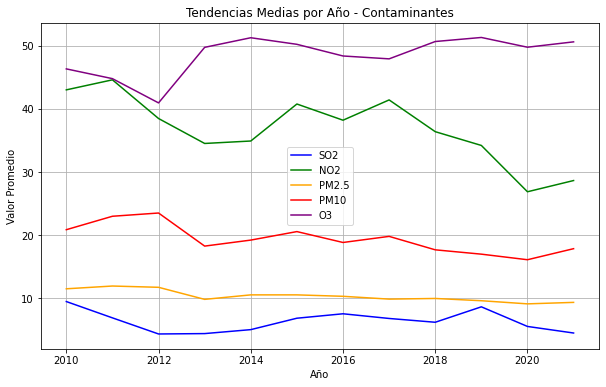

In [37]:
# Calcular las medias por año
contaminantes = ['SO2', 'NO2', 'PM2.5', 'PM10', 'O3']
media_anual = ts_magnitudes.groupby('ANO').mean()

# Grafico
plt.figure(figsize=(10, 6))

colors = ['blue', 'green', 'orange', 'red', 'purple']
for i, contaminante in enumerate(contaminantes):
    plt.plot(media_anual.index, media_anual[contaminante], color=colors[i], label=contaminante)

plt.title('Tendencias Medias por Año - Contaminantes')
plt.xlabel('Año')
plt.ylabel('Valor Promedio')
plt.legend() # Buscar mejor sitio
plt.grid(True)

plt.show()

**Por zonas geográficas**

Durante el proceso de imputación de los valores no verificados, habíamos examinado la distribución por zonas.

In [39]:
# Visualizacion
df_estaciones.head(5)

ESTACION,8,48,50,11,4,47,54,16,57,55,27,59,58,24,56,18,17,MAGNITUD
date,,,,,,,,,,,,,,,,,,
2010-01-01,9.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,7.0,0.0,5.0,7.0,1
2010-02-01,10.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,7.0,0.0,6.0,7.0,1
2010-03-01,11.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,8.0,0.0,10.0,8.0,1
2010-04-01,12.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,8.0,0.0,10.0,8.0,1
2010-05-01,12.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,8.0,0.0,10.0,8.0,1


**Nota:** Crear un mapa de la Comunidad de Madrid con las zonas agrupadas y representar el índice de calidad mediante el uso de colores en cada zona.

## 1.4 Outliers

In [ ]:
# Boxplot
magnitudes = ts_magnitudes[['SO2','NO2','PM2.5','PM10','O3']]
fig = plt.figure(figsize=(5,3))
plt.boxplot(magnitudes)
plt.xticks([1,2,3,4,5], ['SO2','NO2', 'PM2.5','PM10','O3'])
plt.title('Outliers')
plt.show()

In [ ]:
# Outliers
plt.figure(plt.figure(figsize=(20,5)))
plt.subplot(151);plt.plot(ts_magnitudes['SO2']);plt.axhline(y=20, color='red');plt.title('SO2')
plt.subplot(152);plt.plot(ts_magnitudes['NO2']);plt.axhline(y=110, color='red');plt.title('NO2')
plt.subplot(153);plt.plot(ts_magnitudes['PM2.5']);plt.axhline(y=50, color='red');plt.title('PM2.5')
plt.subplot(154);plt.plot(ts_magnitudes['PM10']);plt.axhline(y=150, color='red');plt.title('PM10')
plt.show()

In [ ]:
# Estudio de los outliers para ver si son outliers en más variables
ts_magnitudes[ts_magnitudes['NO2']>110] # PM2.5 tambien es outlier 
ts_magnitudes[ts_magnitudes['PM2.5']>50] # La mayoria de PM10 tambien son outliers
ts_magnitudes[ts_magnitudes['PM10']>150] # La mayoria de PM2.5 tambien son outliers

Imputamos los valores que consideramos como outliers mediante interpolación

In [ ]:
# Cambiamos los valores a NaN
ts_magnitudes.loc[ts_magnitudes['NO2'] > 110, 'NO2'] = np.nan
ts_magnitudes.loc[ts_magnitudes['PM2.5'] > 50, 'PM2.5'] = np.nan
ts_magnitudes.loc[ts_magnitudes['PM10'] > 110, 'PM10'] = np.nan

# Imputamos esos valores
ts_magnitudes['NO2'].interpolate(inplace=True)
ts_magnitudes['PM2.5'].interpolate(inplace=True)
ts_magnitudes['PM10'].interpolate(inplace=True)

# 2. Índice de Calidad del Aire

En primer lugar, vamos a crear un indice de calidad del aire. Así, para cada magnitud determinamos el indice de la forma descrita al principio.

## 2.1 Por magnitudes

| Contaminantes | id| Muy bueno | Bueno | Regular | Malo | Muy malo |
| :- |:- |:-|:-|:-|:-| :-|
|Partículas PM2,5| 9| 0-15|16-30|31-55|56-110|>110|
|Partículas PM10| 10| 0-25|26-50|51-90|91-180|>180|
|NO2| 8| 0-50|51-100|101-200|201-400|>400|
|O3| 14|0-60|61-120|121-180|181-240|>240|
|SO2| 1|0-50|51-100|101-350|351-500|>500|

In [ ]:
# Indice para S02
# Definimos los rangos
bins = [0,50,100,350,500,float("inf")]
labels = [1,2,3,4,5]
# Creamos una columna con el indice
ts_magnitudes["I1"] = pd.cut(ts_magnitudes["SO2"], bins=bins, labels=labels)

# Indice para N02
bins = [0,50,100,200,400,float("inf")]
ts_magnitudes["I2"] = pd.cut(ts_magnitudes["NO2"], bins=bins, labels=labels)

# Indice para PM2.5
bins = [0,15,30,55,110,float("inf")]
ts_magnitudes["I3"] = pd.cut(ts_magnitudes["PM2.5"], bins=bins, labels=labels)

# Indice para PM10
bins = [0,25,50,90,180,float("inf")]
ts_magnitudes["I4"] = pd.cut(ts_magnitudes["PM10"], bins=bins, labels=labels)

# Indice para O3
bins = [0,60,120,180,240,float("inf")]
ts_magnitudes["I5"] = pd.cut(ts_magnitudes["O3"], bins=bins, labels=labels)

In [ ]:
ts_magnitudes

Para crear un índice general, realizamos un PCA y un Kernel PCA en las variables que indican índice.

**PCA**

In [ ]:
# Librerias
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import GridSearchCV

Buscamos el número de componentes óptimo mediante GridSearchCV

In [ ]:
# Indices a los que vamos a aplicar el PCA
indices = ['I1','I2','I3','I4','I5']
# Creamos el objeto
pca = PCA()

# Hiperpametro para el numero de componentes 
parametros = {'n_components': list(range(1, 6))}

# Definimos la búsqueda + CV
cv = GridSearchCV(pca, parametros, cv=5, n_jobs=-1)
cv.fit(ts_magnitudes[indices])

# Resultados
print("Mejor número de componentes: ", cv.best_params_['n_components'])
print("Varianza explicada por cada componente: ", cv.best_estimator_.explained_variance_ratio_)

La varianza explicada por una componente es de un $47\%$, mientras que con dos componentes logramos casi un $80\%$.

Así, tomaríamos dos componentes

In [ ]:
# PCA con 2 componentes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(ts_magnitudes[indices])
X_pca

Mapa con cada estacion que mida cuantos contaminantes hay.

**Kernel PCA**

In [ ]:
# Librerias
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [ ]:
# Columnas a las que aplicamos Kernel PCA
indices = df_comp_mag[['I1','I1','I3','I4','I5']]

# Creamos el objeto
kpca = KernelPCA()

# Cremoas la tuberia
pipe = Pipeline([
    ('kpca', KernelPCA())
])

rango_gamma = np.linspace(0, 1, 10)
ks = list(range(1,6))

# Hiperparametros para GridSearchCV
h_parametros = { 'kpca_gamma': rango_gamma,
    'num_comp': ks}

# Definimos la búsqueda + CV, con la métrica a optimizar
cv = GridSearchCV(pipe, h_parametros, cv=5, n_jobs=-1, scoring = 'r2')
cv.fit(indices)

cv.best_estimator_

## 2.2 Por zonas

# 3. Predicción de la serie temporal

## 3.1 Series temporales univariantes por contaminante

Meter retardos como las columnas para ajustar un modelo de mach learning y hacer shuffle

añadir: Retardos por zona colindantes (vecindario)

añadir: estudio multivariante con vecinos por zonas

Modelos especificos geolocalizados: kriging, 

- Kernel PCA
- Autoencoder

**Nota**:Para intentar ajustar un modelo, cogemos una estacion para tener un dato por día.

In [ ]:
ts = df_comp_mag[df_comp_mag['ESTACION']==8]
ts

**SO2**

Vamos a estudiar la serie temporal para el contaminante $SO_2$. 

In [ ]:
# Librerias
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
so2 = ts[['date','SO2']]
so2 = so2.set_index('date')
so2

In [ ]:
so2.plot(lw=1.5, color='midnightblue', figsize=(20, 8))
plt.title('Monthly PM 2.5 Particulate Concentration', fontsize=16)
plt.xlabel('')
plt.ylabel('ug/m^3', fontsize=12)
plt.grid()
plt.show();

In [ ]:
from statsmodels.graphics.tsaplots import month_plot

fig, ax = plt.subplots(figsize=(20,8))
month_plot(so2,ylabel = 'Concentracion ug/m^3',ax=ax)
plt.title('Monthly PM 2.5 Concentration')
plt.xlabel('month')
plt.ylabel('um/m^3',fontsize)
plt.grid();


In [ ]:
# Descomposicion de la serie temporal
result = seasonal_decompose(so2,period=365)

# Resultados
print(result.trend)
print(result.seasonal)
print(result.resid)